# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import các thư viện

In [ ]:
!pip install pyvi
!pip install underthesea
!mkdir -p /content/drive/MyDrive/NLP/Models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 19.6 MB/s eta 0:00:00


In [ ]:
# !pip install google-auth --upgrade # Make sure you have the latest version
import pandas as pd
from pyvi import ViTokenizer
from underthesea import sent_tokenize
import re
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, f1_score, precision_score, classification_report
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

# Đọc bộ dữ liệu

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/Data/processed_data.csv')
df.shape

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/NLP/Data/processed_data.csv'

### Loại bỏ các giá trị null

In [ ]:
df = df.dropna()
df = df.reset_index(drop=True)
df

# Train - Test Split

In [ ]:
X = df['sent_tokens']   #X = df['2_Comment']
y = df['Label']

# Tách thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Train Model

In [ ]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train)
y = pd.to_numeric(y_train, errors='coerce').astype(int)

y = y.reset_index(drop=True)

# K-Fold cross-validation on the training set
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_nb = []
results_knn = []
results_rf = []

for train_index, test_index in kf.split(X): # Split the training set
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index] # Use iloc to access by position

    # Naive Bayes
    nb_model = MultinomialNB()
    nb_model.fit(X_train_fold, y_train_fold) # Fit with fold data
    nb_pred = nb_model.predict(X_test_fold) # Predict on validation fold

    # KNN
    knn_model = KNeighborsClassifier(metric = 'cosine', n_neighbors = 5)
    knn_model.fit(X_train_fold, y_train_fold) # Fit with fold data
    knn_pred = knn_model.predict(X_test_fold) # Predict on validation fold

    #Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_features="log2")
    rf_model.fit(X_train_fold, y_train_fold) # Fit with fold data
    rf_pred = rf_model.predict(X_test_fold) # Predict on validation fold

    # Append results to lists
    results_nb.append({
        'f1': f1_score(y_test_fold, nb_pred, pos_label = 0),
        'recall': recall_score(y_test_fold, nb_pred, pos_label = 0),
        'precision': precision_score(y_test_fold, nb_pred, pos_label = 0)
    })

    results_knn.append({
        'f1': f1_score(y_test_fold, knn_pred, pos_label = 0),
        'recall': recall_score(y_test_fold, knn_pred, pos_label = 0),
        'precision': precision_score(y_test_fold, knn_pred, pos_label = 0)
    })

    results_rf.append({
        'f1': f1_score(y_test_fold, rf_pred, pos_label = 0),
        'recall': recall_score(y_test_fold, rf_pred, pos_label = 0),
        'precision': precision_score(y_test_fold, rf_pred, pos_label = 0)
    })

avg_f1_nb = np.mean([result['f1'] for result in results_nb])
print(f"Average Naive Bayes F1: {np.mean([result['f1'] for result in results_nb]):.2f}")
print(f"Average Naive Bayes Recall: {np.mean([result['recall'] for result in results_nb]):.2f}")
print(f"Average Naive Bayes Precision: {np.mean([result['precision'] for result in results_nb]):.2f}")
print('---------------')
print(f"Average KNN F1: {np.mean([result['f1'] for result in results_knn]):.2f}")
print(f"Average KNN Recall: {np.mean([result['recall'] for result in results_knn]):.2f}")
print(f"Average KNN Precision: {np.mean([result['precision'] for result in results_knn]):.2f}")
print('---------------')
print(f"Average RF F1: {np.mean([result['f1'] for result in results_rf]):.2f}")
print(f"Average RF Recall: {np.mean([result['recall'] for result in results_rf]):.2f}")
print(f"Average RF Precision: {np.mean([result['precision'] for result in results_rf]):.2f}")
print('---------------')

Average Naive Bayes F1: 0.75
Average Naive Bayes Recall: 0.65
Average Naive Bayes Precision: 0.89
---------------
Average KNN F1: 0.77
Average KNN Recall: 0.74
Average KNN Precision: 0.81
---------------
Average RF F1: 0.77
Average RF Recall: 0.71
Average RF Precision: 0.85
---------------


# Dự đoán trên tập test

In [ ]:
# Vectorize test data
X_test_vectorized = vectorizer.transform(X_test)

# Dự báo
nb_predictions = nb_model.predict(X_test_vectorized)
knn_predictions = knn_model.predict(X_test_vectorized)
rf_predictions = rf_model.predict(X_test_vectorized)

nb_recall = recall_score(y_test, nb_predictions, pos_label = 0)
knn_recall = recall_score(y_test, knn_predictions, pos_label = 0)
rf_recall = recall_score(y_test, rf_predictions, pos_label = 0)

nb_precision = precision_score(y_test, nb_predictions, pos_label = 0)
knn_precision = precision_score(y_test, knn_predictions, pos_label = 0)
rf_precision = precision_score(y_test, rf_predictions, pos_label = 0)

nb_f1 = f1_score(y_test, nb_predictions, pos_label = 0)
knn_f1 = f1_score(y_test, knn_predictions, pos_label = 0)
rf_f1 = f1_score(y_test, rf_predictions, pos_label = 0)

print(f"Naive Bayes Recall: {nb_recall:.2f}")
print(f"KNN Recall: {knn_recall:.2f}")
print(f"Random Forest Recall: {rf_recall:.2f}")
print('---------------')
print(f"Naive Bayes Precision: {nb_precision:.2f}")
print(f"KNN Precision: {knn_precision:.2f}")
print(f"Random Forest Precision: {rf_precision:.2f}")
print('---------------')
print(f"Naive Bayes F1: {nb_f1:.2f}")
print(f"KNN F1: {knn_f1:.2f}")
print(f"Random Forest F1: {rf_f1:.2f}")


Naive Bayes Recall: 0.61
KNN Recall: 0.78
Random Forest Recall: 0.70
---------------
Naive Bayes Precision: 0.93
KNN Precision: 0.95
Random Forest Precision: 0.94
---------------
Naive Bayes F1: 0.74
KNN F1: 0.86
Random Forest F1: 0.80


In [ ]:
filename = '/content/drive/MyDrive/NLP/Models/vectorizer.sav'
pickle.dump(vectorizer, open(filename, 'wb'))

### So sánh kết quả dự đoán của 3 thuật toán với nhãn đúng của quan sát

In [ ]:
# Convert y_test to a numerical format that accuracy_score can understand
y_test = pd.to_numeric(y_test, errors='coerce').astype(int)
# Resetting index can also resolve the issue if y_test has non-positional index
y_test = y_test.reset_index(drop=True)

# Create the DataFrame
results_df = pd.DataFrame({
    'Comment': X_test.reset_index(drop=True),
    'NB_Prediction': nb_predictions,
    'KNN_Prediction': knn_predictions,
    'RF_Prediction': rf_predictions,
    'True_Label': y_test
})

results_df

### Ma trận nhầm lẫn của ba thuật toán trên tập test

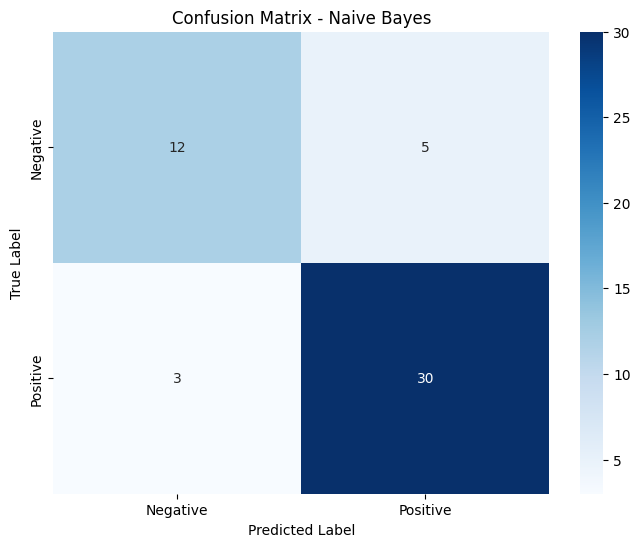

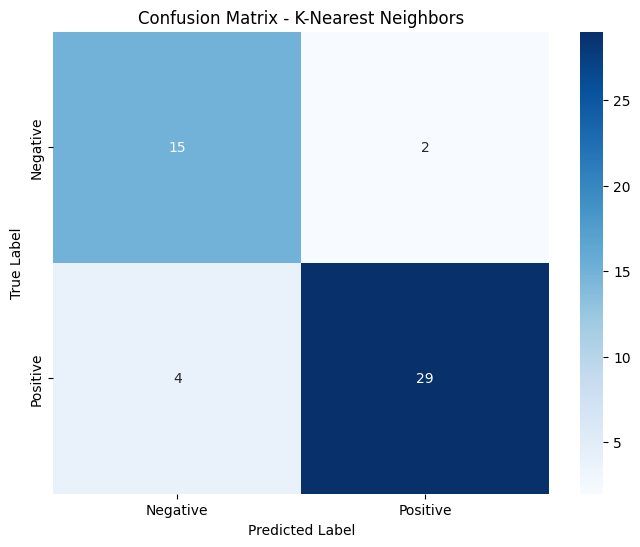

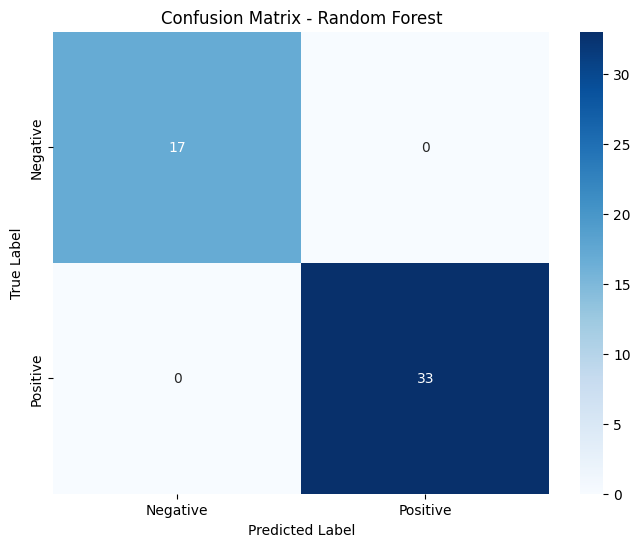

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_test, nb_predictions, 'Naive Bayes')
plot_confusion_matrix(y_test, knn_predictions, 'K-Nearest Neighbors')
plot_confusion_matrix(y_test, rf_predictions, 'Random Forest')

# Điều chỉnh siêu tham số

### Không gian tìm kiếm

In [ ]:
# Define the parameter grid for each model
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}

param_grid_knn = {
    'n_neighbors': [8, 10, 12, 14],  # Số lượng hàng xóm
    'metric': ['cosine', 'manhattan', 'euclidean']
}

param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

custom_f1_scorer = make_scorer(f1_score, pos_label=0)

## Tìm kiếm tham số tối ưu cho thuật toán Naive Bayes và đánh giá trên tập test

Best parameters for Naive Bayes: {'alpha': 0.5}
Best F1 score for Naive Bayes: 0.7899884402632139
NB_Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       0.83      0.89      0.86        27

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



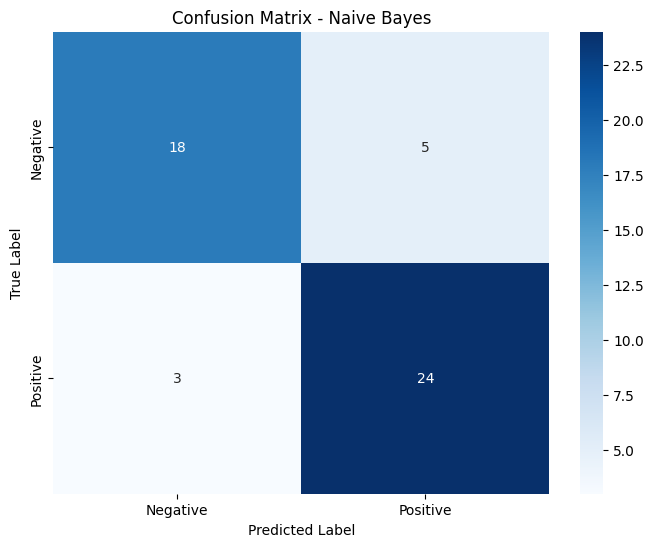

In [ ]:
grid_search_nb_f1 = GridSearchCV(nb_model, param_grid_nb, cv=kf, scoring=custom_f1_scorer)
grid_search_nb_f1.fit(X, y)
print("Best parameters for Naive Bayes:", grid_search_nb_f1.best_params_)
print("Best F1 score for Naive Bayes:", grid_search_nb_f1.best_score_)

best_nb_model = grid_search_nb_f1.best_estimator_
y_pred_nb = best_nb_model.predict(X_test_vectorized)
print("NB_Classification Report:\n", classification_report(y_test, y_pred_nb))
plot_confusion_matrix(y_test, y_pred_nb, 'Naive Bayes')

## Tìm kiếm tham số tối ưu cho thuật toán KNN và đánh giá trên tập test

Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10}
Best F1 score for KNN: 0.7965153576622174
KNN_Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86        23
           1       0.86      0.93      0.89        27

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



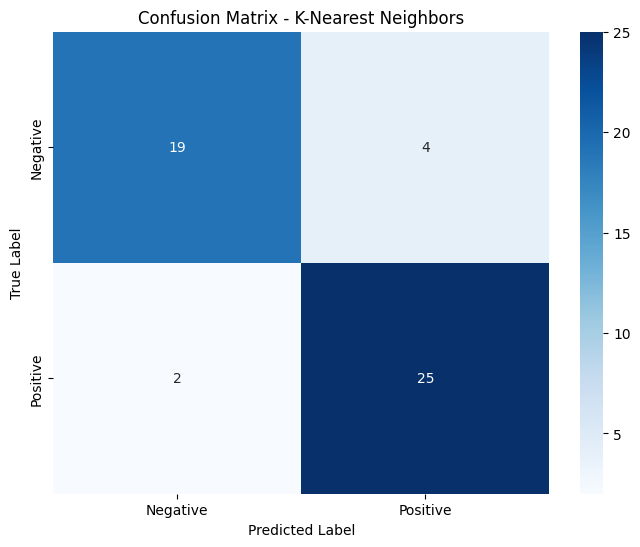

In [ ]:
grid_search_knn_f1 = GridSearchCV(knn_model, param_grid_knn, cv=kf, scoring=custom_f1_scorer)
grid_search_knn_f1.fit(X, y)
print("Best parameters for KNN:", grid_search_knn_f1.best_params_)
print("Best F1 score for KNN:", grid_search_knn_f1.best_score_)

best_knn_model = grid_search_knn_f1.best_estimator_
y_pred_knn = best_knn_model.predict(X_test_vectorized)
print("KNN_Classification Report:\n", classification_report(y_test, y_pred_knn))
plot_confusion_matrix(y_test, y_pred_knn, 'K-Nearest Neighbors')

## Tìm kiếm tham số tối ưu cho thuật toán Random Forest và đánh giá trên tập test

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best F1 score for Random Forest: 0.7829967562398352
RF_Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.88        23
           1       0.87      0.96      0.91        27

    accuracy                           0.90        50
   macro avg       0.91      0.89      0.90        50
weighted avg       0.91      0.90      0.90        50



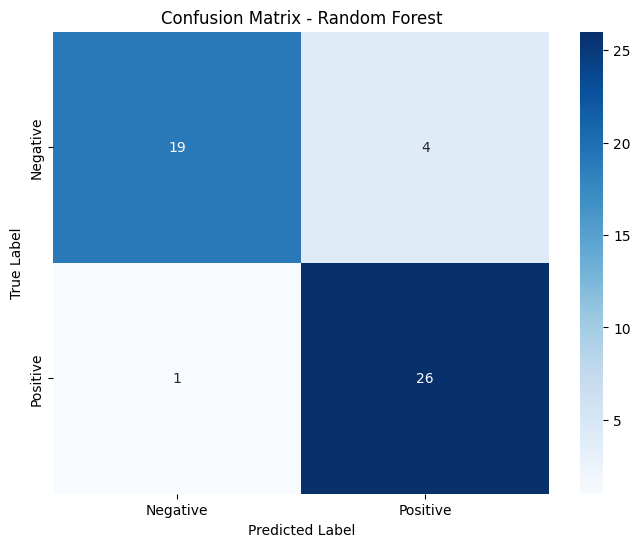

In [ ]:
grid_search_rf_f1 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=kf, scoring=custom_f1_scorer)
grid_search_rf_f1.fit(X, y)
print("Best parameters for Random Forest:", grid_search_rf_f1.best_params_)
print("Best F1 score for Random Forest:", grid_search_rf_f1.best_score_)

best_rf_model = grid_search_rf_f1.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_vectorized)
print("RF_Classification Report:\n", classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')

In [ ]:
with open('/content/drive/MyDrive/NLP/Models/best_nb_model.sav', 'wb') as f:
    pickle.dump(best_nb_model, f)

with open('/content/drive/MyDrive/NLP/Models/best_knn_model.sav', 'wb') as f:
    pickle.dump(best_knn_model, f)

with open('/content/drive/MyDrive/NLP/Models/best_rf_model.sav', 'wb') as f:
    pickle.dump(best_rf_model, f)

RF_Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        33

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



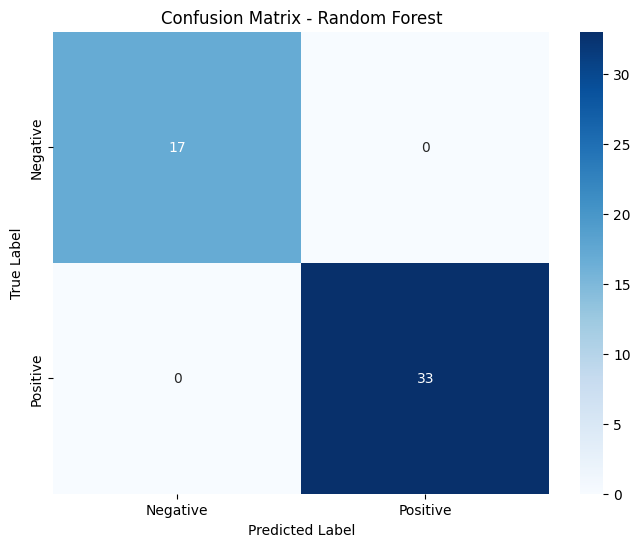

In [ ]:
# prompt: lấy mô hình rf_model đã được train ở bên trên, gán những tham số đầu vào này vào {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

# # Load the saved Random Forest model
# with open('/content/drive/MyDrive/NLP/Models/best_rf_model.sav', 'rb') as f:
#     rf_model = pickle.load(f)

# Set the parameters
best_rf_model = rf_model.set_params(**{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150})

y_pred_rf = rf_model.predict(X_test_vectorized)
print("RF_Classification Report:\n", classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')

In [ ]:
with open('/content/gdrive/MyDrive/NLP/Models/best_rf_model.sav', 'wb') as f:
    pickle.dump(best_rf_model, f)

In [ ]:
# prompt: kiểm tra xem đã lưu được file vào đúng đường dẫn chưa

from google.colab import drive
import os

# Mount Google Drive
# drive.mount('/content/drive')

# Specify the file path
file_path = '/content/drive/MyDrive/NLP/Models/best_rf_model.sav'

# Check if the file exists
if os.path.exists(file_path):
  print(f"File '{file_path}' exists in Google Drive.")
else:
  print(f"File '{file_path}' does not exist in Google Drive.")

File '/content/drive/MyDrive/NLP/Models/best_rf_model.sav' exists in Google Drive.
